In [1]:
import geopandas as gpd
import pandas as pd
import eecisc
import seaborn
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 7)

In [2]:
SOURCE_PATH = "/notebooks/sjoin_selection_arcgis.shp"
PROCESSED_PATH = "/notebooks/processed.shp"
ADJACENCY_PATH = "/notebooks/adjacency.csv"
source = eecisc.read_shapefile(SOURCE_PATH)
processed = eecisc.read_shapefile(PROCESSED_PATH)
adjacency = pd.read_csv(eecisc.read_file(ADJACENCY_PATH))

User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········
User name on eecisc: mmxc2
Password: ········


In [3]:
source_only_buildings = source[source.FTC == 1].copy()
source_only_buildings.sort_values(by='GTN', inplace=True)
source_only_buildings.reset_index(inplace=True)

In [4]:
assert source_only_buildings.index.size == processed.index.size
assert (source_only_buildings.GTN == processed.GTN).all()
assert source_only_buildings.geometry.intersects(processed.geometry).all()

# Case Study: Geopandas' Simplify vs ArcGIS

Objective: Determine whether Geopanda's Simplify can be used to replace ArcGIS

# 1. Discovering the best Tolerance Value

Geopandas' Simplify function only takes in one value - tolerance. Section 1 will be dedicated to the task of finding the tolerance value that will return the values closest to what ArcGIS returns.

In [5]:
def compare(tolerance):
    GP_tol = tolerance       #Set the tolerance for simplify
    Arc_change_mask = source_only_buildings.geometry != processed.geometry
    GP_change_mask = source_only_buildings.geometry != source_only_buildings.simplify(GP_tol).geometry
    Both_change_mask = [x and y for x, y in zip(Arc_change_mask, GP_change_mask)]
    Different_change_mask = source_only_buildings[Both_change_mask].simplify(GP_tol).geometry != processed[Both_change_mask].geometry

    building_data ={'ArcGIS': Arc_change_mask,                #Returns True if ArcGIS changes source buildings
                   'Geopandas': GP_change_mask,                #Returns True if GP Simplify changes source buildings
                   'Both': Both_change_mask,                  #Returns True if both GP and ArcGIS made changes to same building
                   'Different change': Different_change_mask}  #Returns True if the changes by GP and ArcGIS are different

    building_df = pd.DataFrame(building_data, columns = ['ArcGIS', 'Geopandas', 'Both', 'Different change'])
    return building_df

# 1.1 Smallest Number of Geometric Differences

Below are my attempts to find the tolerance value that would minimise the difference in number of geometrically different buildings between ArcGIS and Geopandas' Simplify

In [6]:
comparison_data = {'Geopandas': [],
                   'Both': [],
                   'Different': [],
                  }
test_range1 = [x/100 for x in range(1,50)]

for i in test_range1:
    comparison_data['Geopandas'].append(compare(i)['Geopandas'].sum())
    comparison_data['Both'].append(compare(i)['Both'].sum())
    comparison_data['Different'].append(compare(i)['Different change'].sum())
    

In [7]:
ngd_comparison = pd.DataFrame(comparison_data, index = test_range1)

In [8]:
#ngd_comparison

In [9]:
def best_tolerance(comparison, typ, minimum):
    if minimum:
        minormax = (min(comparison[typ].values))
        print (minormax)
    elif minimum == False:
        minormax = (max(comparison[typ].values))
        print (minormax)
    else: 
        print ('Error')
    for i in comparison[typ].index:
        if minormax == comparison[typ][i]:
            print(i, end='  ')
    print ('\n')
    
best_tolerance(ngd_comparison, 'Geopandas', True)   
#Prints out minimum number of buildings changed by Geopandas' simplify and the range of tolerance required

best_tolerance(ngd_comparison, 'Both', False)       
#Prints out maximum number of buildings changed by BOTH Geopandas and ArcGIS and the range of tolerance required

best_tolerance(ngd_comparison, 'Different', True)  
#Prints out the minimum number of buildings with different changes due to GP and Arc.


188
0.01  

80
0.39  0.4  0.41  0.42  0.43  0.44  0.45  0.46  0.47  0.48  0.49  

41
0.01  



As can be seen from the above data, it is nearly impossible to reduce the number of buildings changed by GP Simplify to 80 (which is the number affected by ArcGIS) without reducing the tolerance to very low levels.

It is obvious that Geopandas' Simplified is much more aggressive than ArcGIS in altering buildings. We thus need to consider how large the effect of these alterations are (section 2)

Of these 80 buildings, based on the data above, the tolerance which gives us the minimum difference between the GP-Simplified and ArcGIS altered buildings will be in the range of 0.4-0.43, giving us 38 similar buildings. 

However, the range of 0.4-0.43 is only marginally better than the rest. Going to lower tolerances also reduces the number of total altered buildings so the range of 0.32-0.38 may be a better option. 

### 1.1a Exception Case Building 85

When tolerance > 0.38, there are NO ArcGIS processed buildings that are not altered by Geopandas Simplify. 80 out of the 80 ArcGIS buildings are altered by Geopandas

When tolerance <= 0.38, there is one building that ArcGIS has altered that Geopandas did not.

In [10]:
exception = compare(0.38)
for x in exception.index:
    if exception['Geopandas'][x]==False and exception['ArcGIS'][x]==True:
        print (x)
    

85


In [11]:
building85 = source_only_buildings.ix[85]
processed_building85 = processed.ix[85]

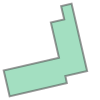

In [12]:
building85.geometry

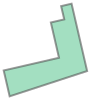

In [13]:
processed_building85.geometry

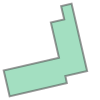

In [14]:
building85.geometry.simplify(0.38)

In [15]:
area_difference = processed.area[85]-source_only_buildings.simplify(0.38).area[85]
area_difference

-0.70839999702610079

In [16]:
pv85 =  processed.geometry.map(lambda x: len(x.exterior.coords))[85]
sv85 = source_only_buildings.simplify(0.34).geometry.map(lambda x: len(x.exterior.coords))[85]
sv85-pv85

2

The ArcGIS area has decreased and two vertices are removed. Not sure why this has happened for ArcGIS but not for Geopanda. May need to check the surrounding buildings to check the effect of this change by ArcGIS. 

*** Originally, the goal of this study was to determine the geopanda tolerance that led to most similar result with ArcGIS. After some discussion of results already collected, there may be a shift in focus from trying to copy ArcGIS with Geopandas to trying to achieve ArcGIS' main goal with Geopandas instead.

As far as I know, the main objective of ArcGIS' Simplify tool is to reduce the number of vertices while trying to minimise area differences between the altered buildings and the source buildings.

If that is the objective of ArcGIS, then it is possible to achieve that objective even better with Geopandas. In Section 1.3 I will compare the differences between the Source buildings and Geopandas' buildings. This way, it may be possible to find a tolerance value for Geopandas' that provides simplified polygons with much reduced vertices while retaining the same area - therefore, doing a better job than ArcGIS.

# 1.2 Comparing Differences in Area and Vertices

While 0.4-0.43 may give us the tolerance with the least number of altered buildings, differences in area and vertices are likely to be the most important factor that we should try to control.

In [17]:
#Using comparison_data from above
#Sum up the absolute sum of the difference in area between ArcGIS and GP Simplify altered buildings:

compare_adv = {'GP/Arc Abs Ar Diff': [],
               'GP/Arc Ar Diff': [],
               'GP/Arc Abs Ver': [],
               'GP/Arc Vertices': []}

test_range = [i/100 for i in range(1, 50)]

for i in test_range:
    mask = compare(i).fillna(False)['Geopandas']
    abs_sum_diff = abs(source_only_buildings[mask].simplify(i).area - processed[mask].area).sum()
    sum_diff = (source_only_buildings[mask].simplify(i).area - processed[mask].area).sum()
    s_ver = (source_only_buildings[mask].simplify(i).geometry.map(lambda x: len(x.exterior.coords)))
    p_ver = (processed[mask].geometry.map(lambda x: len(x.exterior.coords)))
    abs_diff_ver = (sum([abs(x-y) for x,y in zip(s_ver.tolist(), p_ver.tolist())]))
    diff_ver = (sum([(x-y) for x,y in zip(s_ver.tolist(), p_ver.tolist())]))
    
    compare_adv['GP/Arc Abs Ar Diff'].append(abs_sum_diff)
    compare_adv['GP/Arc Ar Diff'].append(sum_diff)
    compare_adv['GP/Arc Abs Ver'].append(abs_diff_ver)
    compare_adv['GP/Arc Vertices'].append(diff_ver)
    
adv_comparison = pd.DataFrame(compare_adv, columns = [i for i in compare_adv.keys()], index=test_range)

In [18]:
#adv_comparison
def min_vals(data_frame):
    for column in data_frame.columns:
        print(column, min(abs(data_frame[column])), sep=': \n', end='\n\n')

In [19]:
min_vals(adv_comparison)

GP/Arc Abs Ver: 
291

GP/Arc Abs Ar Diff: 
13.1756499617

GP/Arc Ar Diff: 
0.385099975823

GP/Arc Vertices: 
186



In [20]:
print(min(adv_comparison['GP/Arc Abs Ar Diff']))
print(min(abs(adv_comparison['GP/Arc Ar Diff'])))
print(min(adv_comparison['GP/Arc Abs Ver']))
print(min(abs(adv_comparison['GP/Arc Vertices'])))

13.1756499617
0.385099975823
291
186


In [21]:
def filter(data_frame, variable, limit):
    min_mask = abs(data_frame[variable]) <= limit
    min_mask.fillna(False)
    return data_frame[min_mask]

In [22]:
filter(adv_comparison, 'GP/Arc Abs Ar Diff', 20)

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Ar Diff,GP/Arc Vertices
0.01,298,13.17565,7.94745,-212
0.02,301,13.46005,8.29385,-217
0.03,338,17.35580,11.82550,-186
0.04,320,17.30265,12.17745,-206
0.05,326,19.33730,13.69580,-206
0.24,291,19.98640,4.52520,-265
0.25,291,19.98640,4.52520,-265
0.26,297,17.08195,3.85715,-271
0.27,297,17.08195,3.85715,-271
0.28,298,18.48605,2.45305,-272


In [23]:
a=source_only_buildings.area.sum()
b=processed.area.sum()

c=abs(source_only_buildings.area - processed[mask].area).sum()

d=(source_only_buildings.simplify(0.3).area - source_only_buildings.area).sum()



print (a, b, a-b, ' ', c, d, sep='\n')
#Area of source buildings
#Area of ArcGIS processed buildings
#Difference between source and ArcGIS processed buildings

30261.2821501
30248.7020501
12.5801000192
 
20.8476000122
-10.4753499987


Geopandas has an obviously stronger effect than ArcGIS in reducing the number of Vertices. *This is not necessarily bad

As can be seen above, it is possible to reduce the sum of the area differences to very low levels (0.38510 compared to 12.58 >> only about 3%).

However, it could be that the absolute area difference gives a better indicator of the number of discrepancies in geometry between ArcGIS processed and Geopanda Simplified buildings. In order to understand the significance of this variable, we compare ArcGIS and Geopandas absolute area difference with Source Buildings themselves in Section 1.3

# 1.3 Comparison of effect of ArcGIS vs Geopandas on Source Buildings

In [24]:
def add_column(df, array, column_name):
    if len(array) == len(df.index):
        series = pd.Series(array, index=df.index)
        df[column_name] = series
        return df
    else:
        print('Not correct length')

In [25]:
test_range = adv_comparison.index

raw_abs_ad = []
raw_sum_ad = []
raw_abs_ver = []
raw_ver = []

for i in test_range:
    mask = compare(i).fillna(False)['Geopandas']
    abs_ad = abs(source_only_buildings[mask].simplify(i).area - source_only_buildings[mask].area).sum()
    sum_ad = (source_only_buildings[mask].simplify(i).area - source_only_buildings[mask].area).sum()
    s_ver = (source_only_buildings[mask].simplify(i).geometry.map(lambda x: len(x.exterior.coords)))
    r_ver = (source_only_buildings[mask].geometry.map(lambda x: len(x.exterior.coords)))
    abs_diff_ver = (sum([abs(x-y) for x,y in zip(s_ver.tolist(), r_ver.tolist())]))
    diff_ver = (sum([(x-y) for x,y in zip(s_ver.tolist(), r_ver.tolist())]))
    raw_abs_ad.append(abs_ad)
    raw_sum_ad.append(sum_ad)
    
    raw_abs_ver.append(abs_diff_ver)
    raw_ver.append(diff_ver)

In [26]:
adv2_data = {'Raw/GP Abs Ar Diff': raw_abs_ad,
            'Raw/GP Ar Diff': raw_sum_ad,
            'Raw/GP Abs Ver': raw_abs_ver,
            'Raw/GP Ver': raw_ver}
adv2_comparison = pd.DataFrame(adv2_data, index=test_range)

In [28]:
adv_comparison

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Ar Diff,GP/Arc Vertices
0.01,298,13.17565,7.94745,-212
0.02,301,13.46005,8.29385,-217
0.03,338,17.35580,11.82550,-186
0.04,320,17.30265,12.17745,-206
0.05,326,19.33730,13.69580,-206
0.06,324,20.12470,12.82480,-210
0.07,325,21.89750,10.84830,-211
0.08,322,21.74635,10.81125,-214
0.09,310,20.87740,10.22870,-226
0.10,308,22.61115,11.02365,-234


In [30]:
#print(min(adv_comparison['Raw/GP Abs Ar Diff']))
#print(min(abs(adv_comparison['Raw/GP Ar Diff'])))
full_comparison = pd.concat([adv_comparison, adv2_comparison, ngd_comparison], axis=1)

In [31]:
full_comparison

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Ar Diff,GP/Arc Vertices,Raw/GP Abs Ar Diff,Raw/GP Abs Ver,Raw/GP Ar Diff,Raw/GP Ver,Both,Different,Geopandas
0.01,298,13.17565,7.94745,-212,3.55960,358,-0.46790,-358,69,41,188
0.02,301,13.46005,8.29385,-217,3.81880,368,-0.56460,-368,71,42,190
0.03,338,17.35580,11.82550,-186,4.66810,394,-0.33780,-394,74,45,194
0.04,320,17.30265,12.17745,-206,5.42695,414,0.01415,-414,74,44,194
0.05,326,19.33730,13.69580,-206,6.87535,426,0.94535,-426,76,46,197
0.06,324,20.12470,12.82480,-210,7.81435,430,0.07435,-430,76,46,197
0.07,325,21.89750,10.84830,-211,8.74470,437,-0.73070,-437,77,47,199
0.08,322,21.74635,10.81125,-214,8.78175,440,-0.76775,-440,77,47,199
0.09,310,20.87740,10.22870,-226,10.26680,453,-0.43060,-453,78,47,200
0.10,308,22.61115,11.02365,-234,12.45965,461,0.36435,-461,78,47,200


In [33]:
filter (full_comparison, 'Raw/GP Ar Diff', 17)

,GP/Arc Abs Ver,GP/Arc Abs Ar Diff,GP/Arc Ar Diff,GP/Arc Vertices,Raw/GP Abs Ar Diff,Raw/GP Abs Ver,Raw/GP Ar Diff,Raw/GP Ver,Both,Different,Geopandas
0.01,298,13.17565,7.94745,-212,3.55960,358,-0.46790,-358,69,41,188
0.02,301,13.46005,8.29385,-217,3.81880,368,-0.56460,-368,71,42,190
0.03,338,17.35580,11.82550,-186,4.66810,394,-0.33780,-394,74,45,194
0.04,320,17.30265,12.17745,-206,5.42695,414,0.01415,-414,74,44,194
0.05,326,19.33730,13.69580,-206,6.87535,426,0.94535,-426,76,46,197
0.06,324,20.12470,12.82480,-210,7.81435,430,0.07435,-430,76,46,197
0.07,325,21.89750,10.84830,-211,8.74470,437,-0.73070,-437,77,47,199
0.08,322,21.74635,10.81125,-214,8.78175,440,-0.76775,-440,77,47,199
0.09,310,20.87740,10.22870,-226,10.26680,453,-0.43060,-453,78,47,200
0.10,308,22.61115,11.02365,-234,12.45965,461,0.36435,-461,78,47,200


In [32]:
min_vals(full_comparison)

GP/Arc Abs Ver: 
291

GP/Arc Abs Ar Diff: 
13.1756499617

GP/Arc Ar Diff: 
0.385099975823

GP/Arc Vertices: 
186

Raw/GP Abs Ar Diff: 
3.5595999827

Raw/GP Abs Ver: 
358

Raw/GP Ar Diff: 
0.0141500124945

Raw/GP Ver: 
358

Both: 
69

Different: 
41

Geopandas: 
188



Based on the above data, reasonable values for tolerance to reduce differences in Area would be 0.32-0.34

# Using Tolerance=0.4

We shall first use a tolerance of 0.4 to test out the differences in GP-Simplified and ArcGIS altered buildings. 

There are 2 variables of particular interest - area and vertices. 

Below are calculations to find the altered buildings with the greatest difference in area and vertices:

In [ ]:
test_tol = 0.35

#Code is not elegant here but it is simply extracting the index of the altered buildings that are not similar
#i.e. index of buildings in the 'Different change' column

Different_mask = compare(test_tol)['Different change']

int_list = [i for i, x in enumerate(Different_mask) if x==True]
int_list_index = [i for i in Different_mask.index]

dbuildings = []
for i in int_list:
    dbuildings.append(int_list_index[i])
    
difference_in_area = []
for i in dbuildings:
    difference_in_area.append((source_only_buildings.simplify(test_tol).area[i]-processed.area[i]))

dbuilding_data = {'index': dbuildings,
                 'Area Difference': difference_in_area}

db_df = pd.DataFrame(difference_in_area, columns=['Area Difference'], index = dbuildings)

db_df.sort_values(by='Area Difference', ascending=False)

Below is the code to generate a dataframe to see the difference in 